In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
from tqdm import tqdm
import seaborn as sns

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable tensorflow warnings

In [2]:
from metrics import anderson_darling, kendall_error

# Import data

In [3]:
data = pd.read_csv("data_train_log_return.csv", header=None).drop(columns=[0])
data.columns = [f'index{i}' for i in range(1, 5)]
data

,index1,index2,index3,index4
0,0.012495,0.011126,0.003252,0.006625
1,0.011439,0.002691,0.001206,0.006947
2,0.000632,0.007277,0.004049,0.000074
3,0.017828,0.028210,0.007758,0.007382
4,0.021115,0.019642,0.009238,0.011499
...,...,...,...,...
741,0.001938,0.008833,0.003927,0.005106
742,0.005003,0.018943,0.003057,0.001988
743,0.007683,0.001958,0.007002,0.006467
744,0.003396,0.001280,0.007621,0.001680


In [4]:
data = data.values

# VAE

In [5]:
%%capture capt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Create the model

In [6]:
class VAE(tf.keras.Model):

    def __init__(self, latent_dim, input_dim=data.shape[1]):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(input_dim,)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                # No activation
                tf.keras.layers.Dense(latent_dim + latent_dim),
            ]
        )

        self.decoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                tf.keras.layers.Dense(128, activation='relu'),
                tf.keras.layers.Dense(64, activation='relu'),
                # No activation
                tf.keras.layers.Dense(input_dim)
            ]
        )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(data.shape[0], self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.decoder(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [7]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis)


def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent)
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
    """Executes one training step and returns the loss.

    This function computes the loss and gradients, and uses the latter to
    update the model's parameters.
    """
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [8]:
def generate_samples(model, test_sample):
    mean, logvar = model.encode(test_sample)
    z = model.reparameterize(mean, logvar)
    predictions = model.sample(z)
    return predictions, mean, logvar, z

### Training

In [9]:
X = tf.cast(data, dtype=tf.float32)

In [10]:
def histogram(ax, data, label=""):
    sns.histplot(data, kde=True, ax=ax, stat='density', label=label)
    ax.legend()
    ax.set_ylabel('')
    ax.set_xlabel('')

def plot_distribution(model, generated_sample, title='', save=None):
    fig, axs = plt.subplots(4, 3, figsize=(11, 8))
    for i in range(4):
        histogram(axs[i][0], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][1], generated_sample[:, i], label=f'Generated index{i+1}')
        
        histogram(axs[i][2], data[:, i], label=f'True index{i+1}')
        histogram(axs[i][2], generated_sample[:, i], label=f'Generated index{i+1}')
    for ax in axs:
        for ax_i in ax:
            ax_i.legend()

    #plt.tight_layout()
    plt.suptitle(title)
    if save is None:
        plt.show()
    else:
        plt.savefig(save)
        plt.close()

In [11]:
%%capture capt
latent_dim = 3
model = VAE(latent_dim)

optimizer = tf.keras.optimizers.Adam(1e-2)
loss = tf.keras.metrics.Mean()

In [12]:
def compute_metrics(model, generated_sample, errors):
    random_anderson = anderson_darling(data, generated_sample.numpy())
    random_kendall = kendall_error(data, generated_sample.numpy())

    errors['anderson'].append(random_anderson)
    errors['kendall'].append(random_kendall)

In [13]:
def train(model, X, epochs=10_000):
    display_every = 1000
    patience = 1000
    best_elbo = float('-inf')
    no_improvement_count = 0

    errors = {}
    errors['elbo'] = []
    errors['anderson'] = []
    errors['kendall'] = []

    start_time = time.time()
    for epoch in range(1, epochs + 1):
        train_step(model, X, optimizer)

        loss(compute_loss(model, X))
        elbo = -loss.result()
        errors['elbo'].append(elbo)

        # check for patience
        if elbo > best_elbo:
            best_elbo = elbo
            no_improvement_count = 0  # reset the counter
        else:
            no_improvement_count += 1

        if no_improvement_count >= patience:
            display.clear_output(wait=False)
            print(f'Patience! Epoch: {epoch}, ELBO: {elbo}')
            break

        if epoch % display_every == 0 or epoch == 1:
            display.clear_output(wait=False)
            end_time = time.time()
            print(f"Epoch: {epoch}, ELBO: {elbo}, time: {round(end_time-start_time, 4)}s for {display_every} epochs")
            start_time = time.time()

    return errors

In [14]:
try:
    # load the weights of the model if it has been trained already
    model.load_weights('./VAE_checkpoint/')
    print('model loaded from previous train')
except:
    errors = train(model, X)

model loaded from previous train


## Generate new data

### Exponential noise

In [15]:
random_noise = np.random.exponential(1.15e-2, size=(data.shape))
generated_sample, *_ = generate_samples(model, random_noise)

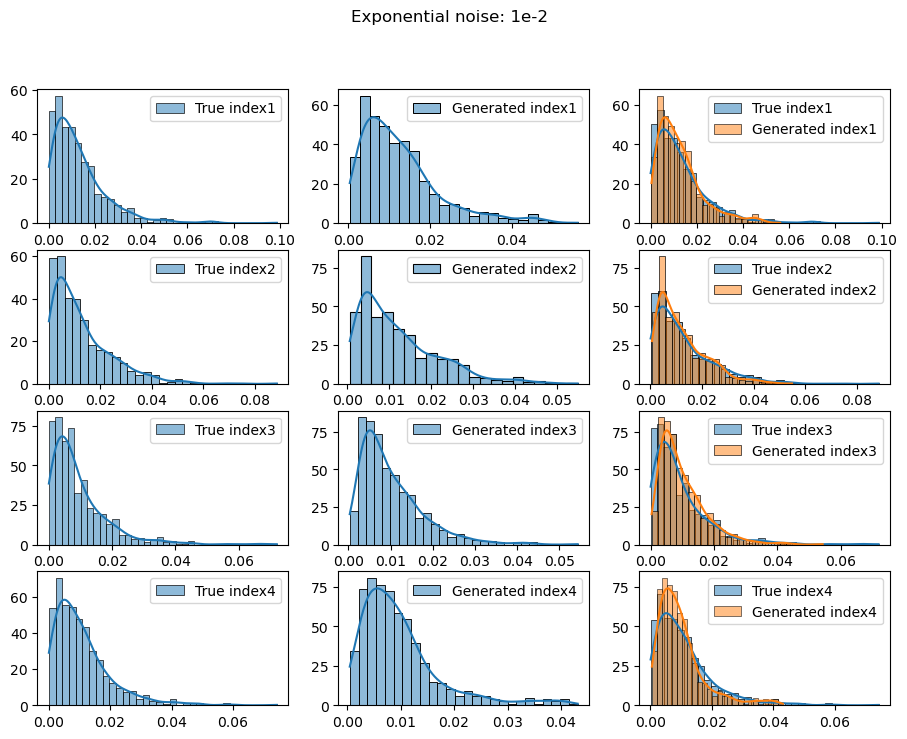

In [16]:
plot_distribution(model, generated_sample, title='Exponential noise: 1e-2')

In [17]:
anderson_darling(data, generated_sample.numpy())

14.659486219435365

In [18]:
kendall_error(data, generated_sample.numpy())

0.05238857800888857

### Gaussian noise

In [19]:
random_noise = np.random.normal(0, 2e-2, size=(data.shape))
generated_sample, *_ = generate_samples(model, random_noise)

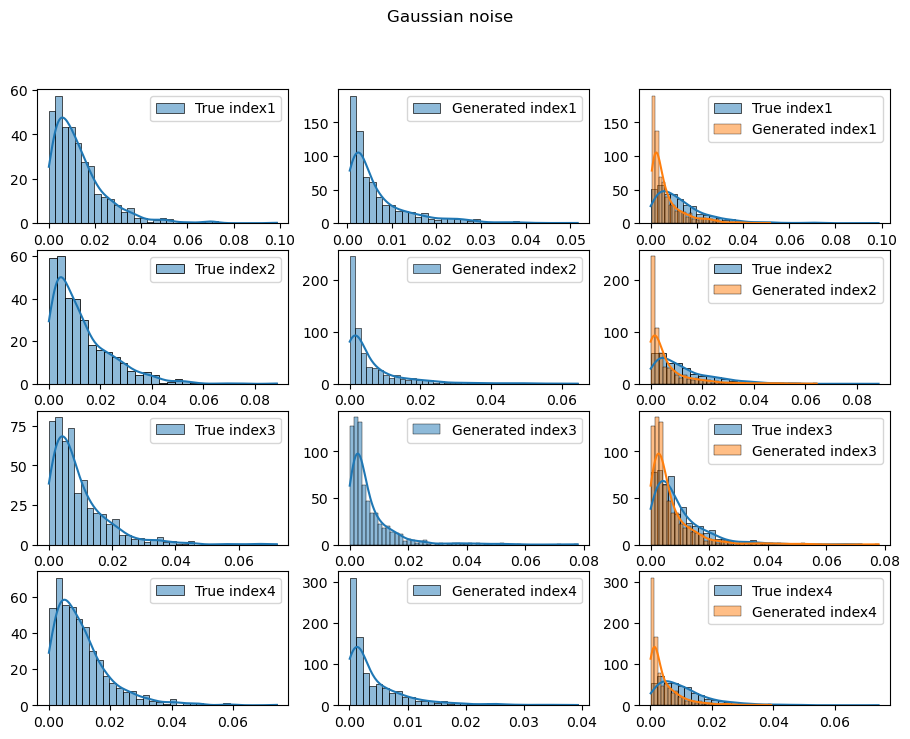

In [20]:
plot_distribution(model, generated_sample, title='Gaussian noise')

In [21]:
anderson_darling(data, generated_sample.numpy())

258.2816629069009

In [22]:
kendall_error(data, generated_sample.numpy())

0.05393957932238155

### Absolute Gaussian noise

In [23]:
random_noise = abs(np.random.normal(0, 1.15e-2, size=(data.shape)))
generated_sample, *_ = generate_samples(model, random_noise)

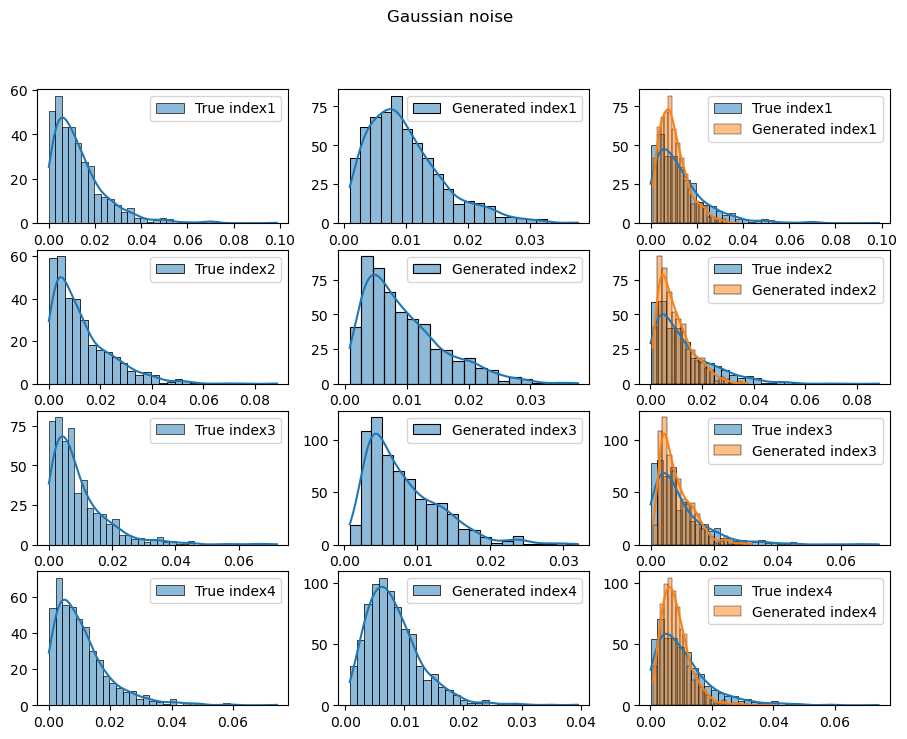

In [24]:
plot_distribution(model, generated_sample, title='Gaussian noise')

In [25]:
anderson_darling(data, generated_sample.numpy())

36.071828076411805

In [26]:
kendall_error(data, generated_sample.numpy())

0.055319646616406065

## Generate test sample

In [27]:
random_noise = np.random.exponential(1.15e-2, size=(410, 4))
test_sample, mean, logvar, latent_var = generate_samples(model, random_noise)

In [28]:
np.random.shuffle(data)
data_test = data[:410]

In [29]:
test_anderson = anderson_darling(data_test, test_sample.numpy())
test_kendall = kendall_error(data_test, test_sample.numpy())

print(f'On generated test sample, Anderson-Darling = {round(test_anderson, 4)}; Kendall error = {round(test_kendall, 3)}')

On generated test sample, Anderson-Darling = 6.3152; Kendall error = 0.055


In [30]:
latent_var_df = pd.DataFrame(latent_var.numpy(), columns=[f'latent_var_feature_{i}' for i in range(latent_var.shape[1])])
latent_var_df.head(3)

,latent_var_feature_0,latent_var_feature_1,latent_var_feature_2
0,0.424379,0.136048,-2.254519
1,1.934267,-0.511590,-1.580361
2,-2.654597,-0.752588,0.532817


In [31]:
generated_samples_df = pd.DataFrame(test_sample.numpy(), columns=[f'index_{i}' for i in range(1, 5)])
generated_samples_df.head(3)

,index_1,index_2,index_3,index_4
0,0.002825,0.001976,0.001829,0.002060
1,0.001464,0.005226,0.004254,0.001551
2,0.009620,0.009193,0.001755,0.041476


In [32]:
latent_var_df.to_csv('Result/VAE_latent_dim_3/latent_variables.csv', index=False)

In [33]:
generated_samples_df.to_csv('Result/VAE_latent_dim_3/generated_samples.csv', index=False)